# Проект: классификация

In [2971]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2972]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [2973]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [2974]:
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [2975]:
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

balance    0.223974
dtype: float64

In [2976]:
drop_data = df['balance'].dropna(how='any', axis=0)

In [2977]:
drop_data

0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11137, dtype: object

In [2978]:
df['balance'] = drop_data.apply(lambda arg: float(arg.replace('$','').replace(',','.').replace(' ','')))

In [2979]:
df['balance'].mean()

1529.1290293615875

### Задание 4

In [2980]:
df['balance'] = df['balance'].fillna(df['balance'].median())

In [2981]:
df['balance'].mean()

1526.9360329690019

### Задание 5

In [2982]:
df['job'].mode()

0    management
Name: job, dtype: object

In [2983]:
df['job'] = df['job'].apply(lambda arg: 'management' if arg=='unknown' else arg)

In [2984]:
df['education'].mode()

0    secondary
Name: education, dtype: object

In [2985]:
df['education'] = df['education'].apply(lambda arg: 'secondary' if arg=='unknown' else arg)

In [2986]:
df_filter = df[(df['job']=='management') & (df['education']=='secondary')]

In [2987]:
round(df_filter['balance'].mean(),3)

1598.883

### Задание 6

In [2988]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [2989]:
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [2990]:
%pip install plotly

In [2991]:
%pip install nbformat 

In [2992]:
import plotly.express as px

In [2993]:
fig = px.box(cleaned, x="balance")
fig.show()

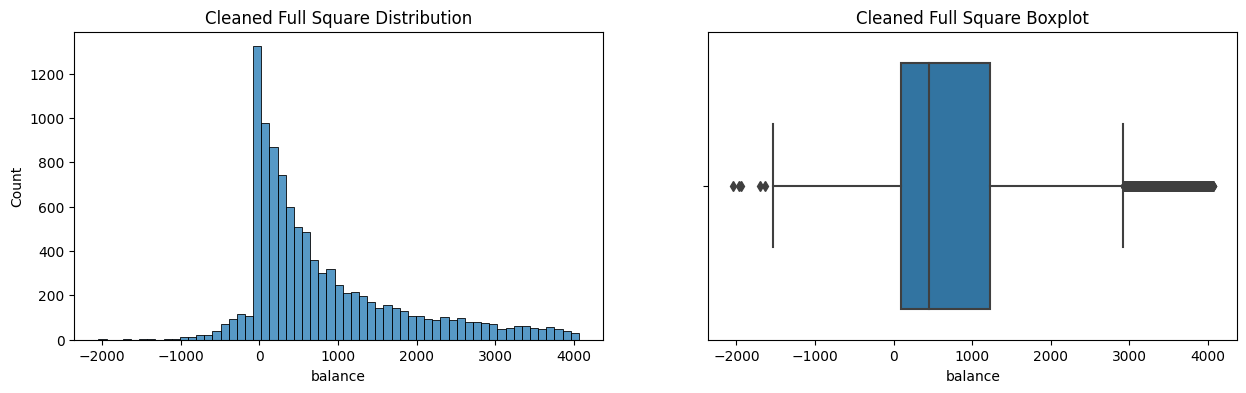

In [2994]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

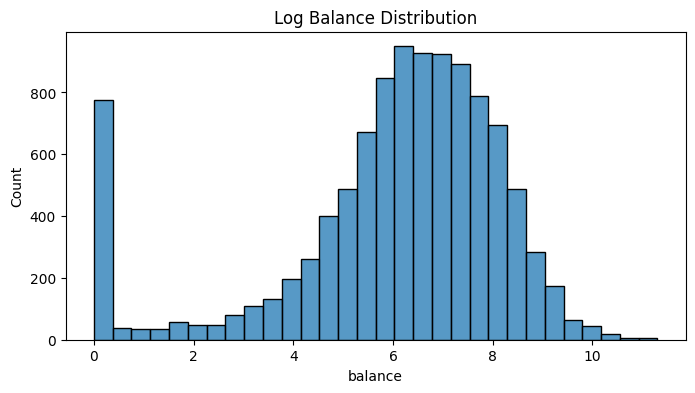

In [2995]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_balance = np.log(df['balance'] + 1)
histplot = sns.histplot(log_balance, bins=30, ax=ax)
histplot.axvline(log_balance.mean(), color='k', lw=2)
histplot.axvline(log_balance.mean()+ 3 * log_balance.std(), color='k', ls='--', lw=2)
histplot.axvline(log_balance.mean()- 3 * log_balance.std(), color='k', ls='--', lw=2)
histplot.set_title('Log Balance Distribution');

## Часть 2:  Разведывательный анализ

### Задание 1

Данные о клиентах банка:

+ age (возраст);
+ job (сфера занятости);
+ marital (семейное положение);
+ education (уровень образования);
+ default (имеется ли просроченный кредит);
+ housing (имеется ли кредит на жильё);
+ loan (имеется ли кредит на личные нужды);
+ balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

+ contact (тип контакта с клиентом);
+ month (месяц, в котором был последний контакт);
+ day (день, в который был последний контакт);
+ duration (продолжительность контакта в секундах).

Прочие признаки:

+ campaign (количество контактов с этим клиентом в течение текущей кампании);
+ pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
+ previous (количество контактов до текущей кампании)
+ poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [2996]:
df['contact'].value_counts()

contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64

In [2997]:
df['poutcome'].value_counts()

poutcome
unknown    8326
failure    1228
success    1071
other       537
Name: count, dtype: int64

In [2998]:
df = cleaned

In [2999]:
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

-0.13698377581120946


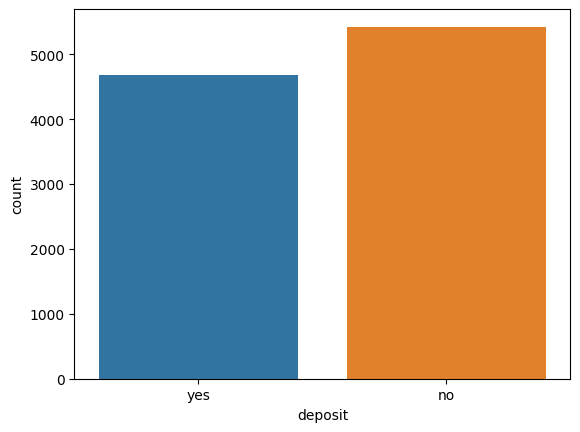

In [3000]:
# Проверяем сбалансированность целевого признака.
sns.countplot(data=df, x='deposit');
print(df['deposit'].value_counts()[1]/ df['deposit'].value_counts()[0]-1)

### Задания 2 и 3

In [3001]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [3002]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

In [3003]:
len(df['month'].value_counts())

12

In [3004]:
len(df['job'].value_counts())

11

### Задания 4 и 5

In [3005]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

<Axes: xlabel='poutcome'>

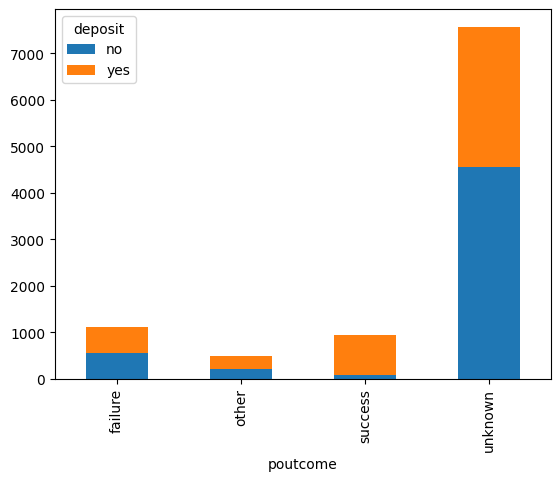

In [3006]:
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

<Axes: xlabel='month'>

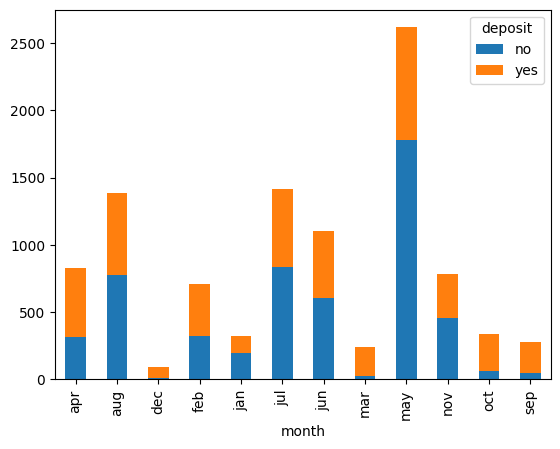

In [3007]:
types = df.groupby("month")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 7

<Axes: xlabel='age_group', ylabel='count'>

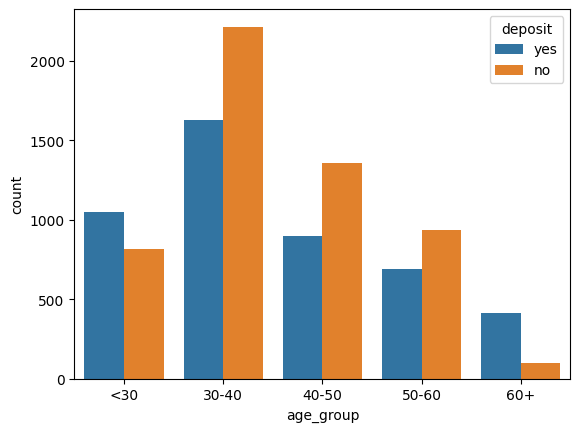

In [3008]:
# Для создания категорий используем метод cut()

df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df)

### Задание 8

<Axes: xlabel='count', ylabel='job'>

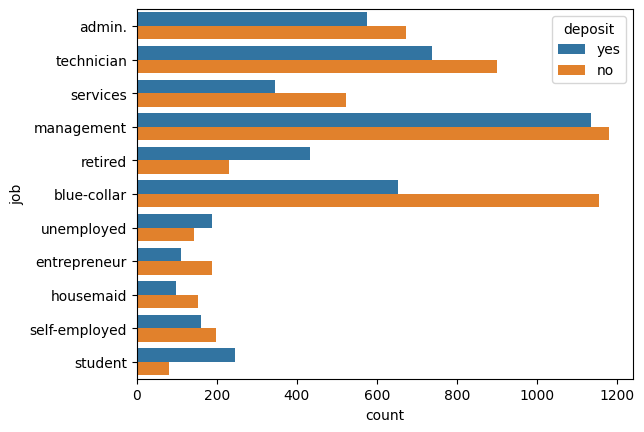

In [3009]:
sns.countplot(y='job', hue='deposit', data=df)

### Задания 9 и 10

<Axes: xlabel='count', ylabel='marital'>

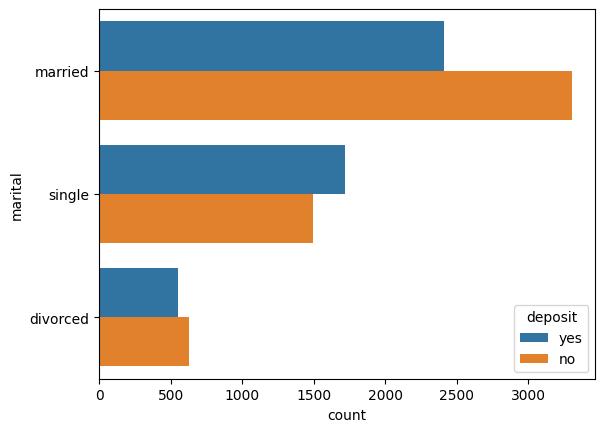

In [3010]:
# Используем countplot() из библиотеки seaborn

sns.countplot(y='marital', hue='deposit', data=df)

In [3011]:
# Для начала отфильтруйте в отдельные таблицы тех, кто согласился открыть депозит, и тех, кто не согласился. После этого 
# составьте сводные таблицы и визуализируйте их с помощью тепловых карт. Рекомендуется использовать crosstab().
df_yes = df[df['deposit']=='yes']
df_no = df[df['deposit']=='no']

In [3012]:
df_yes

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5284,78,retired,divorced,primary,no,1389.0,no,no,cellular,8,apr,335,1,-1,0,unknown,yes,60+
5285,30,management,single,tertiary,no,398.0,no,no,cellular,27,oct,102,1,180,3,success,yes,<30
5286,69,retired,divorced,tertiary,no,247.0,no,no,cellular,22,apr,138,2,-1,0,unknown,yes,60+
5287,48,entrepreneur,married,secondary,no,0.0,no,yes,cellular,28,jul,431,2,-1,0,unknown,yes,40-50


In [3013]:
df_no

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
5289,57,retired,single,primary,no,604.0,no,no,cellular,19,nov,187,1,-1,0,unknown,no,50-60
5290,45,admin.,divorced,secondary,no,0.0,yes,no,cellular,17,nov,102,1,-1,0,unknown,no,40-50
5291,48,blue-collar,married,secondary,no,238.0,yes,yes,cellular,2,jun,118,2,81,1,success,no,40-50
5292,34,admin.,single,secondary,no,673.0,yes,no,cellular,29,jan,89,1,260,2,failure,no,30-40
5294,32,management,married,tertiary,no,3696.0,no,no,unknown,21,may,315,3,-1,0,unknown,no,30-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-40
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-40
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-40
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-50


In [3014]:
res1 = pd.crosstab(df_yes['education'], df_yes['marital'])
res2 = pd.crosstab(df_no['education'], df_no['marital'])

In [3015]:
res1

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


In [3016]:
res2

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


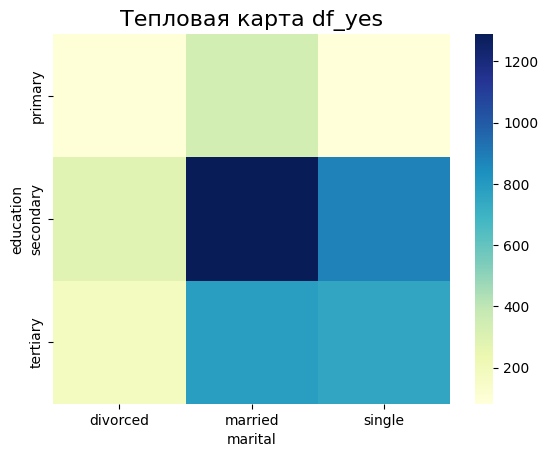

In [3017]:
heatmap = sns.heatmap(data=res1, cmap='YlGnBu')
heatmap.set_title('Тепловая карта df_yes', fontsize=16);

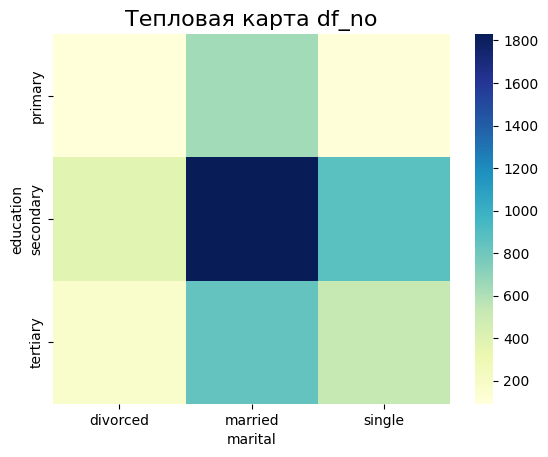

In [3018]:
heatmap = sns.heatmap(data=res2, cmap='YlGnBu')
heatmap.set_title('Тепловая карта df_no', fontsize=16);

### Задание 11

In [3019]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [3020]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df['education'] = lab_enc.fit_transform(df['education'])
df['education'].sum()

11995

In [3021]:
#import category_encoders as ce # импортируем библиотеку для работы с кодировщиками

#ord_encoder = ce.OrdinalEncoder()
#data_bin = ord_encoder.fit_transform(df[['age_group']])
#df = pd.concat([df, data_bin], axis=1)



In [3022]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        10105 non-null  int64   
 1   job        10105 non-null  object  
 2   marital    10105 non-null  object  
 3   education  10105 non-null  int32   
 4   default    10105 non-null  object  
 5   balance    10105 non-null  float64 
 6   housing    10105 non-null  object  
 7   loan       10105 non-null  object  
 8   contact    10105 non-null  object  
 9   day        10105 non-null  int64   
 10  month      10105 non-null  object  
 11  duration   10105 non-null  int64   
 12  campaign   10105 non-null  int64   
 13  pdays      10105 non-null  int64   
 14  previous   10105 non-null  int64   
 15  poutcome   10105 non-null  object  
 16  deposit    10105 non-null  object  
 17  age_group  10105 non-null  category
dtypes: category(1), float64(1), int32(1), int64(6), object(9)
memory usage:

In [3023]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df['age_group'] = lab_enc.fit_transform(df['age_group'])

In [3024]:
#import category_encoders as ce # импортируем библиотеку для работы с кодировщиками

#ord_encoder = ce.OrdinalEncoder()
#data_bin = ord_encoder.fit_transform(df[['age_group']])
#df = pd.concat([df, data_bin], axis=1)

In [3025]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)

In [3026]:
df['deposit'].describe()

count    10105.000000
mean         0.463236
std          0.498671
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: deposit, dtype: float64

In [3027]:
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [3028]:
df['default'].mean()

0.016427511133102424

In [3029]:
df['housing'].value_counts()

housing
0    5243
1    4862
Name: count, dtype: int64

In [3030]:
df['loan'].value_counts()

loan
0    8712
1    1393
Name: count, dtype: int64

In [3031]:
df['default'].mean()+ df['housing'].mean()+ df['loan'].mean()

0.6354280059376547

### Задания 2 и 3

In [3032]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [3033]:
%pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [3034]:
#import category_encoders as ce # импорт для работы с кодировщиком
#col = df[['job', 'marital', 'contact', 'month', 'poutcome']]
#encoder = ce.OneHotEncoder(cols= col) # указываем столбец для кодирования
#type_bin = encoder.fit_transform(col)
#df = pd.concat([df, type_bin], axis=1)

#df

In [3035]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  int32  
 4   default    10105 non-null  int64  
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  int64  
 7   loan       10105 non-null  int64  
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  int64  
 17  age_group  10105 non-null  int32  
dtypes: float64(1), int32(2), int64(10), object(5)
memory usage: 1.4+ MB


In [3036]:
df['job']

0             admin.
1             admin.
2         technician
3           services
4             admin.
            ...     
11157    blue-collar
11158       services
11159     technician
11160     technician
11161     technician
Name: job, Length: 10105, dtype: object

In [3037]:
cols = ['job',
'marital',
'contact',
'month',
'poutcome']
df = pd.get_dummies(df, columns= cols)

### Задания 5 и 6

In [3038]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

In [3039]:
df = df.select_dtypes(exclude='category')

In [3040]:
#df = df.drop(['job', 'marital', 'contact', 'poutcome', 'month'], axis=1)
#df

<Axes: >

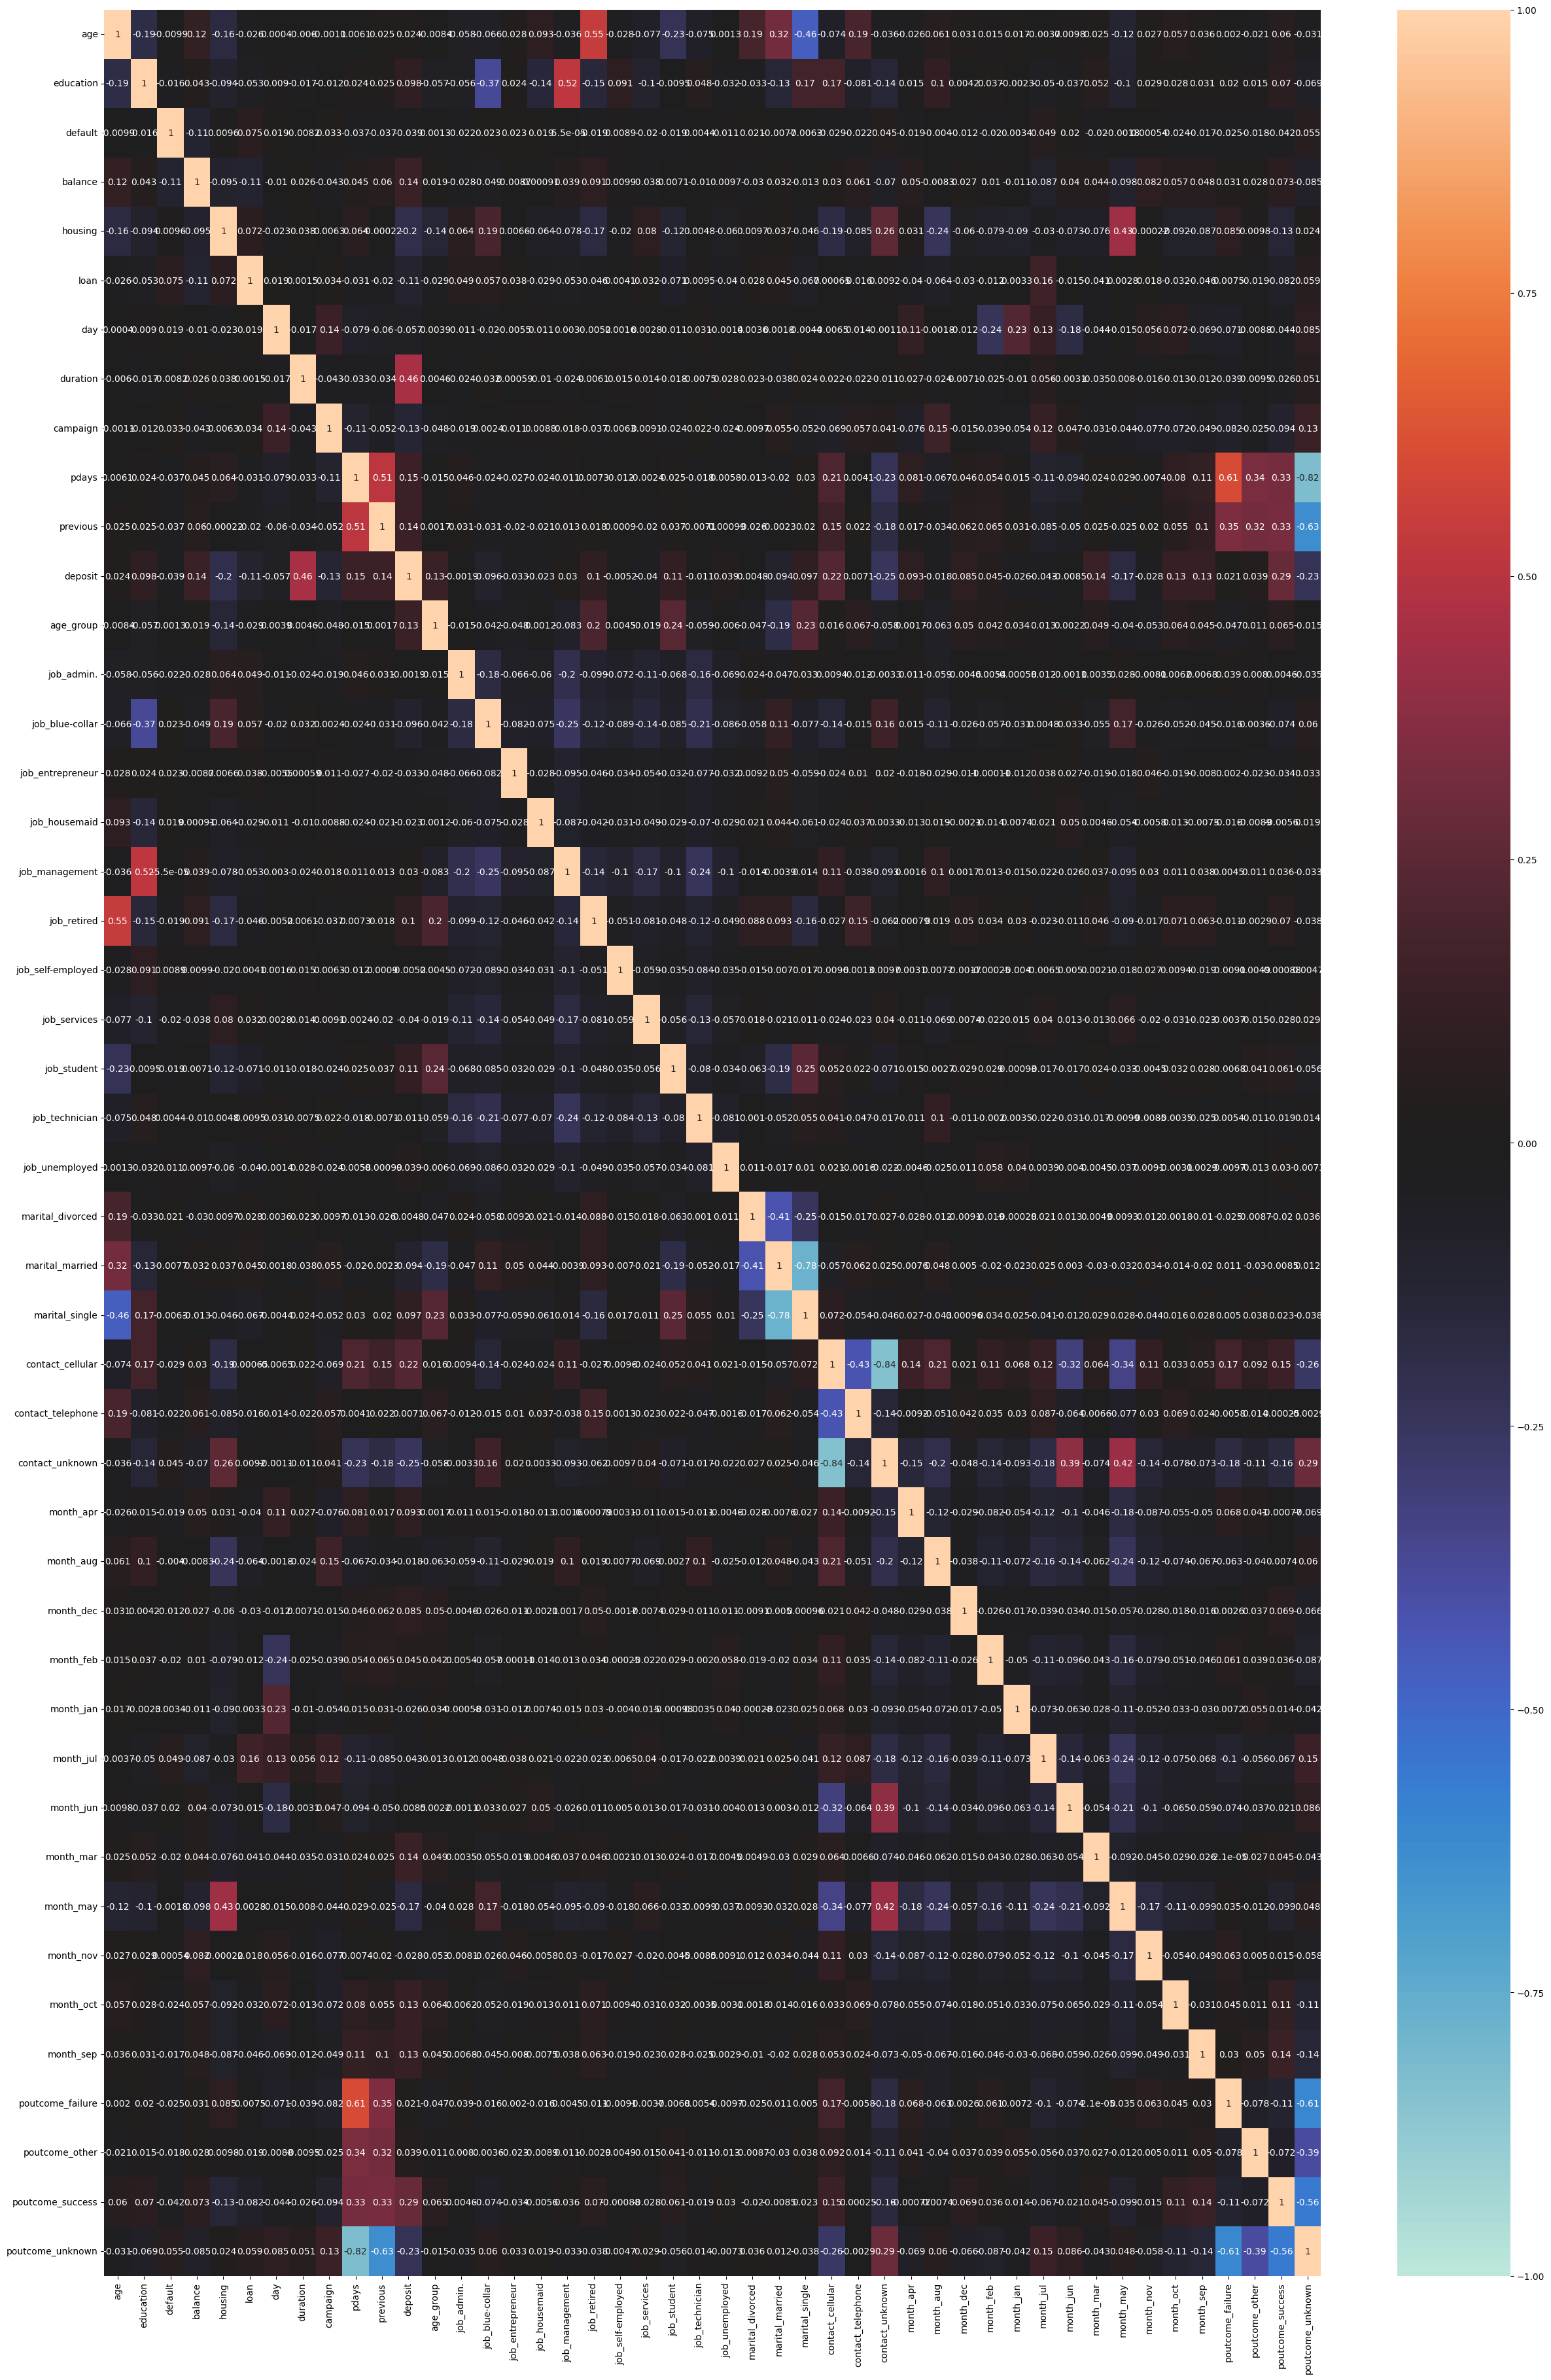

In [3041]:
plt.figure(figsize=(30,45))
corr = df.corr()
sns.heatmap(corr, vmin=-1, center=0, annot=True)

<Axes: >

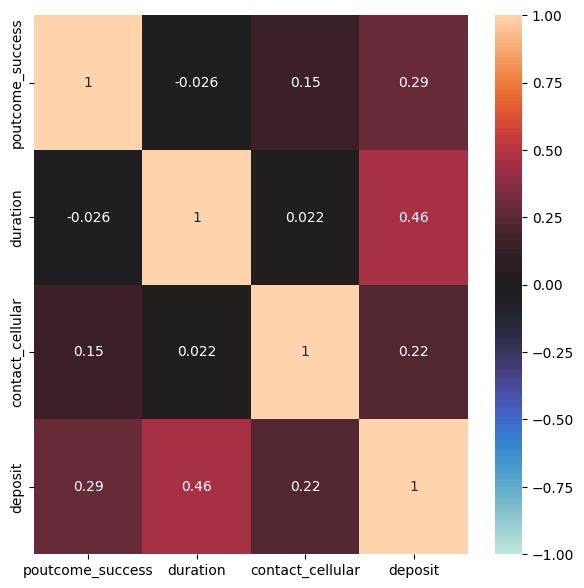

In [3042]:
df_corr = df[['poutcome_success', 'duration', 'contact_cellular', 'deposit']]

plt.figure(figsize=(7,7))
corr = df_corr.corr()
sns.heatmap(corr, vmin=-1, center=0, annot=True)

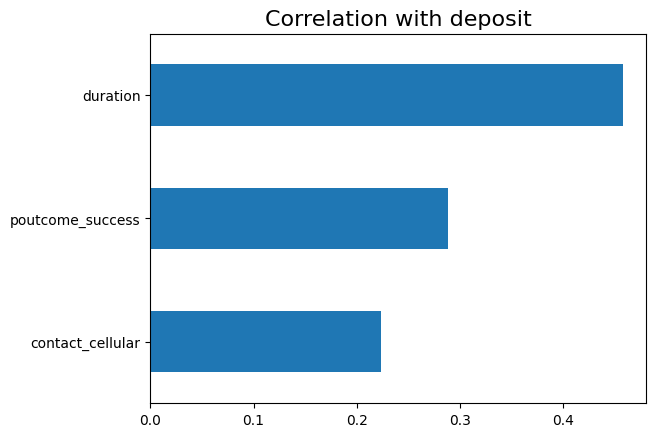

In [3043]:
# Вспоминаем проект 3+

corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

### Задания 7 и 8

In [3044]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [3045]:
X_test.shape

(3335, 45)

In [3046]:
round(y_test.mean(),2)

0.46

In [3047]:
# рассчитайте необходимые показатели

In [3048]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

### Задание 9

In [3049]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [3050]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test)      # fransform() на test данных

print(X_test_scaled[:, 0].mean())  # для признака balance, обратите внимание именно на столбец

0.30879760119940036


In [3051]:
X_test_scaled[:, 0].mean()

0.30879760119940036

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [3052]:
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [3053]:
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)
print('Accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))


Accuracy на тестовом наборе: 0.82


### Задания 2,3,4

In [3054]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [3055]:
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)
print('Accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Accuracy на тренировочном наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

Accuracy на тестовом наборе: 0.80
Accuracy на тренировочном наборе: 0.82


### Задание 5

In [3056]:
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_split':[2, 5, 7, 10],
              'max_depth':[3,5,7]}

              
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)

%time grid_search.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 31.2 ms
Wall time: 249 ms
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [3062]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [3067]:
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1790
           1       0.80      0.86      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.88      0.87      0.87      6770



### Задания 2 и 3

In [3068]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [3069]:
y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1790
           1       0.82      0.88      0.85      1545

    accuracy                           0.86      3335
   macro avg       0.86      0.86      0.86      3335
weighted avg       0.86      0.86      0.86      3335

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      3634
           1       0.90      0.93      0.91      3136

    accuracy                           0.92      6770
   macro avg       0.92      0.92      0.92      6770
weighted avg       0.92      0.92      0.92      6770



### Задание 4

In [3070]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [3071]:
y_train_pred = stack.predict(X_train_scaled)
y_test_pred = stack.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1790
           1       0.83      0.86      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      3634
           1       0.89      0.91      0.90      3136

    accuracy                           0.91      6770
   macro avg       0.91      0.91      0.91      6770
weighted avg       0.91      0.91      0.91      6770



### Задание 5

In [3072]:
from sklearn.feature_selection import RFE
 
estimator = ensemble.GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [ ]:
pip install optuna

In [3081]:
import optuna

In [3084]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state= 42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))
  return score

In [3085]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2023-06-27 16:33:13,081] A new study created in memory with name: RandomForestClassifier
[I 2023-06-27 16:33:13,863] Trial 0 finished with value: 0.9001545595054097 and parameters: {'n_estimators': 137, 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9001545595054097.
[I 2023-06-27 16:33:14,756] Trial 1 finished with value: 0.8996294008647313 and parameters: {'n_estimators': 162, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9001545595054097.
[I 2023-06-27 16:33:15,283] Trial 2 finished with value: 0.866677013813441 and parameters: {'n_estimators': 124, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9001545595054097.
[I 2023-06-27 16:33:16,107] Trial 3 finished with value: 0.8674548848786559 and parameters: {'n_estimators': 196, 'max_depth': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9001545595054097.
[I 2023-06-27 16:33:16,673] Trial 4 finished with value: 0.8686493184634448 and parameters: {'n_e

Наилучшие значения гиперпараметров {'n_estimators': 135, 'max_depth': 26, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.96
CPU times: total: 10.3 s
Wall time: 36.1 s


In [3087]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.85
